<a href="https://colab.research.google.com/github/DYLPICKLEROHAN/previous_work/blob/main/2023_big_data_analysis_and_industry_project/Assessment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Week 1 - word count example
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Assignment 1
## Part 1 - Recommendation system

In researching the capacity of pyspark I found that there are two types of recommendation system inbuilt into pyspark:
1. Content based recommendation systems - uses attributes of instances and clusters them into groups of similarity
2. Collaborative filtering - uses the rating people have given to an instance

But these are not suited to this style of question, they are for making suggstions based on a common attribute value.

In module 2, locality-sensitivity Hashing was demonstrated as a means of identifying similar documents. The idea could be applied to this problem if the user Id somehow reflected the connection and provided a link between users within userids (eg, if every friend you made altereded you userID so that it held a record of that friend then the shingles would indicate similarity).

If we take it back to first principles, then consider this:

Take two friends, A and B. Then the potential friends for B is the set of friends held by A but not by B (or A union B - B)

However in the case of a social network, there could be any number of nodes. Nodes with one degree of seperation are friends, but nodes with two degrees of seperation are either friends or candidate friends. With data of the form (A, [B, C, D,...]), the list can be thought of as a set of two degree seperations (B-A-C, C-A-D, ...). So if for every user, we combine the lists that they themselves are present in, then we will have a set of values that includes the user, the users current friends, and every 2nd degree connection Which I am assuming is the subset of users that are most likely to be friend with the user. So if we create a key-value pair for each user, with the user as the key and the combined lists as the value, then we can remove the friends and user from this list and will be left with a countable list of candidate friends. The combined list effectively represents every relevant edge of the network.



In [ ]:
# Importing modules and setting up a Spark Session
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import split, array, size
from pyspark.sql.types import IntegerType, ArrayType, StringType, StructType, StructField

spark = SparkSession.builder.appName('recommendation_system').getOrCreate()

In [ ]:
# Importing the dataset using the tab as the delimiter in the spark session
## Reading in the file
df = spark.read.csv('/content/drive/MyDrive/aabigdatafiles/soc-LiveJournal1Adj.txt',
                   sep = '\t')

# Checking the data has been read in correctly
df.show()

+---+--------------------+
|_c0|                 _c1|
+---+--------------------+
|  0|1,2,3,4,5,6,7,8,9...|
|  1|0,5,20,135,2409,8...|
|  2|0,117,135,1220,27...|
|  3|0,12,41,55,1532,1...|
|  4|0,8,14,15,18,27,7...|
|  5|0,1,20,2022,22939...|
|  6|0,21,98,2203,3238...|
|  7|0,31993,40218,404...|
|  8|0,4,38,46,72,85,2...|
|  9|  0,6085,18972,19269|
| 10|0,12,16,30,6027,1...|
| 11|0,1754,6027,7789,...|
| 12|0,3,10,16,29,38,4...|
| 13|0,12584,32064,27,...|
| 14|0,4,19,19079,4269...|
| 15|           0,4,27,80|
| 16|0,10,12,18,30,38,...|
| 17|0,19,26,28,95,128...|
| 18|0,4,16,30,89,2406...|
| 19|0,14,17,439,1100,...|
+---+--------------------+
only showing top 20 rows



In [ ]:
# Create an RDD
## Partitions the data accross multiple cores
rdd = df.rdd.map(lambda x: (x[0], x[1]))
rdd = rdd.filter(lambda x: x[1] is not None)                                              # removing unconnected nodes of the social network
print("Confirming output format", rdd.filter(lambda x: x[0] == '924').collect())

# The below was going to use sets as I thought it would be computationally quicker,
# but then I can't order the recommendations based on duplicates because they get removed
rdd1 = rdd.map(lambda x: (x[0], set(x[1].split(","))))
print("Correcting format so the values/friends are in a set", rdd1.filter(lambda x: x[0] == '924').collect())

Confirming output format [('924', '925,926')]
Correcting format so the values/friends are in a set [('924', {'926', '925'})]


In [ ]:
# Creating a duplicate to compare against
user_friends = dict(rdd1.collect())

# Obtaining the set of potential friends for each user (the union of all sets containing X, minus the set of X)
candidates = rdd1.mapValues(lambda friends: set.union(*[user_friends[friend] for friend in friends]) - friends)
print("Checking output", candidates.filter(lambda x: x[0] == '924').collect())

Checking output [('924', {'924', '43748', '45881', '439', '2409', '15416', '11860', '6995'})]


In [ ]:
# Duplicate count relates to the probability of being friends, lets try again with lists (retaining duplicates):
rdd2 = rdd.map(lambda x: (x[0], x[1].split(",")))
print("Checking format", rdd.filter(lambda x: x[0] == '924').collect())

# Creating a dictionary of all relationships to compare against
user_friends = dict(rdd2.collect())

# Obtaining the set of potential friends for each user (the union of all sets containing X, minus the set of X)
candidates = rdd2.mapValues(lambda friends: [friend for friend in sum([user_friends[f] for f in friends], []) if friend not in friends])
print("Checking output", candidates.filter(lambda x: x[0] == '924').collect())

Checking format [('924', '925,926')]
Checking output [('924', ['924', '6995', '439', '924', '2409', '11860', '15416', '43748', '45881'])]


In [ ]:
# Removing all instances of self from the list of candidates
def remove_key_value(pair):
    key, value = pair
    if len(value) == 0:
        return pair
    new_value = [item for item in value if item != key]
    return (key, new_value)

candidates = candidates.map(remove_key_value)
print("Checking output", candidates.filter(lambda x: x[0] == '924').collect())

Checking output [('924', ['6995', '439', '2409', '11860', '15416', '43748', '45881'])]


In [ ]:
# Map each value to a dictionary of word counts
candidate_frequency = candidates.flatMap(lambda x: [(x[0], friend_id) for friend_id in x[1]])
print("Checking output:", candidate_frequency.filter(lambda x: x[0] == '9993').collect())

# Reduce the tuples by key to count the frequency of each friend for each user
result = candidate_frequency.map(lambda x: (x, 1))
result = result.reduceByKey(lambda x, y: x + y).map(lambda x: (x[0][0], (x[0][1], x[1]))).groupByKey().mapValues(list)
print("Checking output:",result.filter(lambda x: x[0] == '9993').collect())

Checking output: [('9993', '9991'), ('9993', '9991'), ('9993', '9991'), ('9993', '9991'), ('9993', '9991'), ('9993', '13134'), ('9993', '13478'), ('9993', '13877'), ('9993', '34299'), ('9993', '34485'), ('9993', '34642'), ('9993', '37941')]
Checking output: [('9993', [('34299', 1), ('13478', 1), ('9991', 5), ('37941', 1), ('13134', 1), ('13877', 1), ('34485', 1), ('34642', 1)])]


In [ ]:
# Creating the required output
import pandas as pd
## Obtaining specific user recommendations
users = result.filter(lambda x: x[0] in ['924', '8941', '8942', '9019', '9020', '9021', '9022', '9990', '9992', '9993'])
## Sorting by likelihood and placing in ascending order for like candidates
#users = users.mapValues(lambda x: sorted(x, key=lambda y: y[1], reverse=True))
users = users.map(lambda x: (x[0], sorted(x[1], key=lambda y: (-y[1], y[0]))))
users = users.map(lambda x: (x[0], sorted(x[1], key=lambda y: (-y[1], y[0]))[:10]))
## Creating a dataframe to visualize the data
users = users.toDF(['User', 'Suggested friends in order of decreasing likelihood'])
users = users.toPandas()
users

,User,Suggested friends in order of decreasing likelihood
0,8942,"[(8939, 3), (8940, 1), (8943, 1), (8944, 1)]"
1,924,"[(11860, 1), (15416, 1), (2409, 1), (43748, 1)..."
2,8941,"[(8943, 2), (8944, 2), (8940, 1)]"
3,9990,"[(13134, 1), (13478, 1), (13877, 1), (34299, 1..."
4,9019,"[(9022, 2), (317, 1), (9023, 1)]"
5,9992,"[(9987, 4), (9989, 4), (35667, 3), (9991, 2)]"
6,9022,"[(9019, 2), (9020, 2), (9021, 2), (317, 1), (9..."
7,9993,"[(9991, 5), (13134, 1), (13478, 1), (13877, 1)..."
8,9020,"[(9021, 3), (9016, 2), (9017, 2), (9022, 2), (..."
9,9021,"[(9020, 3), (9016, 2), (9017, 2), (9022, 2), (..."


In [ ]:
# Preparing the same output without the count
users_of_interest = result.filter(lambda x: x[0] in ['924', '8941', '8942', '9019', '9020', '9021', '9022', '9990', '9992', '9993'])
sorted_users_of_interest = users_of_interest.map(lambda x: (x[0], sorted(x[1], key=lambda y: (-y[1], y[0]))))
top_10_ordered_candidates = sorted_users_of_interest.map(lambda x: (x[0], sorted(x[1], key=lambda y: (-y[1], y[0]))[:10]))
ordered_suggestions = top_10_ordered_candidates.map(lambda x: (x[0], [i[0] for i in x[1]])).collect()
print(ordered_suggestions)

# Presenting as a Dataframe
import pandas as pd
users_df = pd.DataFrame(ordered_suggestions)
users_df.columns = ['User', 'Suggested friends in order of decreasing likelihood']
users_df

[('9993', ['9991', '13134', '13478', '13877', '34299', '34485', '34642', '37941']), ('9020', ['9021', '9016', '9017', '9022', '317', '9023']), ('9021', ['9020', '9016', '9017', '9022', '317', '9023']), ('8942', ['8939', '8940', '8943', '8944']), ('924', ['11860', '15416', '2409', '43748', '439', '45881', '6995']), ('8941', ['8943', '8944', '8940']), ('9019', ['9022', '317', '9023']), ('9990', ['13134', '13478', '13877', '34299', '34485', '34642', '37941']), ('9992', ['9987', '9989', '35667', '9991']), ('9022', ['9019', '9020', '9021', '317', '9016', '9017', '9023'])]


,User,Suggested friends in order of decreasing likelihood
0,9993,"[9991, 13134, 13478, 13877, 34299, 34485, 3464..."
1,9020,"[9021, 9016, 9017, 9022, 317, 9023]"
2,9021,"[9020, 9016, 9017, 9022, 317, 9023]"
3,8942,"[8939, 8940, 8943, 8944]"
4,924,"[11860, 15416, 2409, 43748, 439, 45881, 6995]"
5,8941,"[8943, 8944, 8940]"
6,9019,"[9022, 317, 9023]"
7,9990,"[13134, 13478, 13877, 34299, 34485, 34642, 37941]"
8,9992,"[9987, 9989, 35667, 9991]"
9,9022,"[9019, 9020, 9021, 317, 9016, 9017, 9023]"


In [ ]:
# Saving output in the format specified
users_df.to_csv("assessment 1.txt", sep="\t")

## Part 2 - LSH and the S-curve
To earn the marks, lets start from the beginning...

Imagine you had an enormous collection of documents that you wanted to compare for similarity without needing to go through all of them individually. One way to do this would be to use the words or string of words as a marker of similarity - though this would only relate documents that are physically similar and not necessarily semantically similar. Using single words alone may not narrow it down as needed, and provides no information about their connection. In the case of detecting plagirism that is an important point. Order matters, but arrangement does not. That is to say we need to detect similar phrases no matter where they exist in the text.

Enter k-shingles!
K-shingles provides a method of comparing text in a way that is independent of its location in the document. (I assume they are named after roofing shingles which are the same but overlap in a similar fashion). The sentence "Hello there" could be broken into the 2-shingle units he, el, ll, lo, o_, _t, th, he, er, and re. You can see how they overlap. If we then gathered all the documents, and all the k-shingles we could construct a table indicating the presence of a k-shingle with columns representing documents and rows as k-shingles. This fictitious table is known as a characteristic matrix, and can be quite sparse (lots of zeros). When we have a very large sample size, the memory required to store all that inforamtion is orders of magnitude larger and much of it is not informative (the zeros).

Enter Minhash hashing!
These are hash functions used to replace k-shingles with a much less memory intensive value. This method takes a sort of fingerprint of a document based on the order that the chracteristic matrix's ones appear in for a given column when read from top to bottom in some predetermined permutation. The first row from the top for a given document with a 1 will have its index used as the 'minhash'. This is then done for every column. The probability that this value is the same for two documents is equivalent to the Jaccard similarity.This is because there is a direct link between the calculations.

In practice, this process is too time consuming. Instead of taking random permutations, a hash function is used to generate the minhash signatures that make up the signature matrix. This function will map the row number to particular buckets, ideally unique buckets but in the scheme of things a few collisions are okay. This generates a signature matrix where the columns are still symbolic of the documents contents, and the hash values are representative of the shingles within the document. Columns that are similar represent documents that are similar as they approximate Jacard simialrity. But false positives will exist due to collisions in buckets.

Now, in relation to this question, b and r represent divisions in the signature matrix of b bands and r rows. Each band segment can be hashed to a large number of buckets, so bands that are the same will appear in the same bucket. This reduces the size of the matrix once more.

The probability that the signatures of these bands agree in all the rows, or that the documents are candiate pairs, is given by the equation provided:
$$
1-\left(1-s^r\right)^b
$$

Graphically, the x-axis is the Jaccard similarity, the y-axis is the probability of becoming a candidate pair, and it takes the form of an s-curve. When the probability of becoming a candidate pair is 0.5, you are at the threshold. This position is at s = $(1 / b)^{1 / r}$ . With this in mind, we can select a threshold and determine the best values for b and r by setting that equation equal to the desired threshold (considering the accuracy and the time demands). The threshold you chose is largely dependent on the context of the problem. Using the signatures, we can now calculate the approximate Jacard similarity and determine whether or not it passes the threshold and can be deemed similar.





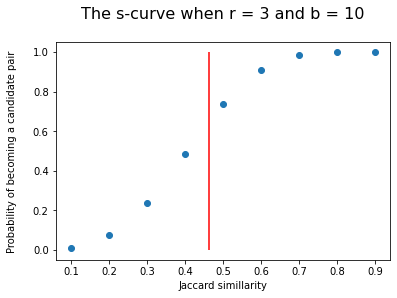

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
r = 3
b = 10
y = []
for val in s:
  z = 1-(1-(val)**r)**b
  y.append(z)

fig = plt.figure()
plt.scatter(s, y)
plt.title("The s-curve when r = 3 and b = 10\n", size=16)
plt.xlabel("Jaccard simillarity")
plt.ylabel("Probability of becoming a candidate pair\n")
threshold = round((1/b)**(1/r),3)
plt.vlines(threshold,0,1, colors = "r")
plt.show()

In [ ]:
print("The threshold for being interpretted as a similar pair with these bands " +
      "is approximately", threshold, "according to the calculation.\n")
pd.DataFrame({'s':s,
              'y':y})

The threshold for being interpretted as a similar pair with these bands is approximately 0.464 according to the calculation.



,s,y
0,0.1,0.009955
1,0.2,0.077181
2,0.3,0.239449
3,0.4,0.483871
4,0.5,0.736924
5,0.6,0.912267
6,0.7,0.985015
7,0.8,0.999234
8,0.9,0.999998


The above demonstrates that a moderate threshold has been selected. Slightly below 0.5 indicates that there may be slightly more false positives than if the threshold was at 0.5 Perhaps the trade off in time is worth the loss of accuracy.

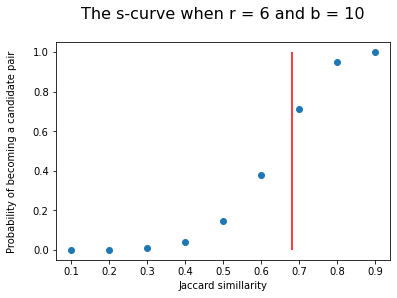

In [ ]:
r = 6
b =10
y = []
for val in s:
  z = 1-(1-(val)**r)**b
  y.append(z)
fig = plt.figure()
plt.scatter(s, y)
plt.title("The s-curve when r = 6 and b = 10\n", size=16)
plt.xlabel("Jaccard simillarity")
plt.ylabel("Probability of becoming a candidate pair\n")
threshold = round((1/b)**(1/r),3)
plt.vlines(threshold,0,1, colors = "r")
plt.show()


In [ ]:
print("The threshold for being interpretted as a similar pair with these bands " +
      "is approximately", threshold, "according to the calculation.\n")
pd.DataFrame({'s':s,
              'y':y})

The threshold for being interpretted as a similar pair with these bands is approximately 0.681 according to the calculation.



,s,y
0,0.1,0.000010
1,0.2,0.000640
2,0.3,0.007266
3,0.4,0.040213
4,0.5,0.145709
5,0.6,0.379851
6,0.7,0.713969
7,0.8,0.952168
8,0.9,0.999490


The threshold here is well over a Jacard similarity of 0.5, meaning it may take longer than the previous run but it will provide more accurate candidate pairs as the threshold is above the Jacard similarity of 0.5.

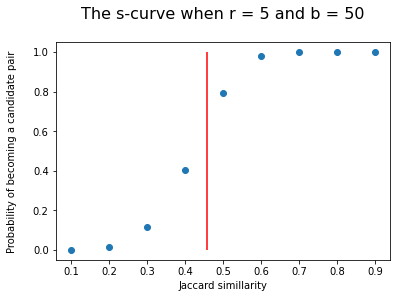

In [ ]:
r = 5
b = 50
y = []
for val in s:
  z = 1-(1-(val)**r)**b
  y.append(z)
fig = plt.figure()
plt.scatter(s, y)
plt.title("The s-curve when r = 5 and b = 50\n", size=16)
plt.xlabel("Jaccard simillarity")
plt.ylabel("Probability of becoming a candidate pair\n")
threshold = round((1/b)**(1/r),3)
plt.vlines(threshold,0,1, colors = "r")
plt.show()

In [ ]:
print("The threshold for being interpretted as a similar pair with these bands " +
      "is approximately", threshold, "according to the calculation.\n")
pd.DataFrame({'s':s,
              'y':y})

The threshold for being interpretted as a similar pair with these bands is approximately 0.457 according to the calculation.



,s,y
0,0.1,0.000500
1,0.2,0.015875
2,0.3,0.114540
3,0.4,0.402284
4,0.5,0.795551
5,0.6,0.982534
6,0.7,0.999899
7,0.8,1.000000
8,0.9,1.000000


Again we have a run where the threshold is below Jacard similarity of 0.5, but this particular curve has a sharper incline which indicates that the probability of having at least one false positive reduces much faster than in the previous runs.

## Part 3 - Filtering Streams
Bloom filters are an ingenious method of identifying similarity to a high degree of probability. The basic prinicple is that a single piece of information can be passed to a number of hash functions and the output creates something of a unique set of values. In theory, if another other item creates the same bucket values, they are the same (however collisions can result in some false positives, but not false negatives). This takes a large dataset and reduce the memory needed and the time it would take to filter through each relation.

For example, in the case of spam emails, if I index the email addresses, i can hash the address with multiple hash functions. If an incoming email doesn't match any of the sets of buckets created by each index, then it is a new email address as it is unique. But if it does match a set of buckets, then the email has been recieved before.

The false positive rate  is $
\left(1-e^{-k m / n}\right)^k
$ where k is the number of hash functions used, m is the number of elements in a set, and n is the size of the array. To minimize the faalse positive rate you need to set K to be equal to $
k=n / m \cdot \ln (2)
$.

In [ ]:
# The case for 1 hash functions
import math
k = 1 #number of hash functions used
m = 2*10**9  # elements in set
n = 10*10**9  # size of array

# False positive rate equation
false_pos_rate = (1-(math.e)**(-k*m/n))**k
print(false_pos_rate)

0.18126924692201818


In [ ]:
# The case for 2 hash functions
import math
k = 2 # number of hash functions used
m = 2*10**9  # elements in set
n = 10*10**9  # size of array

# False positive rate equation
false_pos_rate = (1-(math.e)**(-k*m/n))**k
print(false_pos_rate)

0.10868887204594298


In [ ]:
# The case for 3 hash functions
import math
k = 3 # number of hash functions used
m = 2*10**9  # elements in set
n = 10*10**9  # size of array

# False positive rate equation
false_pos_rate = (1-(math.e)**(-k*m/n))**k
print(false_pos_rate)

0.09184883923294042


In [ ]:
# The case for four hash functions
k = 4 # number of hash functions used
m = 2*10**9  # elements in set
n = 10*10**9  # size of array

# False positive rate equation
false_pos_rate = (1-(math.e)**(-k*m/n))**k
print(false_pos_rate)

0.0919536423197623


In [ ]:
# The case for 5 hash functions
import math
k = 5 # number of hash functions used
m = 2*10**9  # elements in set
n = 10*10**9  # size of array

# False positive rate equation
false_pos_rate = (1-(math.e)**(-k*m/n))**k
print(false_pos_rate)

0.10092519027486131


In [ ]:
# The case for 6 hash functions
import math
k = 6 # number of hash functions used
m = 2*10**9  # elements in set
n = 10*10**9  # size of array

# False positive rate equation
false_pos_rate = (1-(math.e)**(-k*m/n))**k
print(false_pos_rate)

0.11644985740580262


As you can see, the difference between having 3 and 4 hash functions is minimal. But outside of that range it startes to increase by a larger amount.

In [ ]:
# The number of hash functions required to minimize the fale positive rate
k=math.log(2)*(n/m)
print("The number of hash functions required to minimize the false positive rate is:", round(k,3))
print("You can't have 0.466 of a hash function though. So, looking at the values above,", math.floor(k), "is the best choice." )

The number of hash functions required to minimize the false positive rate is: 3.466
You can't have 0.466 of a hash function though. So, looking at the values above, 3 is the best choice.
